# Pooling Polygons

This guide runs through an example of approach building polygons from non-adaptive pooling layers. Sometimes it might be useful to keep model small and concentrate only on particular geographic region, while keeping coordinate system unchanged (e.g. EPSG:4326). For this purpose, Torch Geopooling library provides an option to specify a particular region of interesent.

In [1]:
!pip install scikit-learn -qqq

## Defining Dataset

In this tutorial we demonstrate the idea of restricting geographic area of interest on synthetic data. But conceptually the approach remains the same. Below we generate two interleaving half circles and use them throughout the tutorial. You can adjust the parameters to see how it affects the final solution.

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=400, noise=0.05, random_state=0)

## Complete Regular Tiling

The straight-forward approach would be tiling up the rectangular space comprised from the dataset points. And as you could see from the resulting tiling, which is depicted below, the are regions that do not contain any data points whatsoever. We assume that those regions *won't* contain any points in testing subset as well.

In [3]:
import torch
from shapely import Polygon
from torch_geopooling.nn import QuadPool2d


xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

bounding_box = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
pool = QuadPool2d(1, polygon=bounding_box, exterior=(-10, -10, 20, 20), max_depth=8)

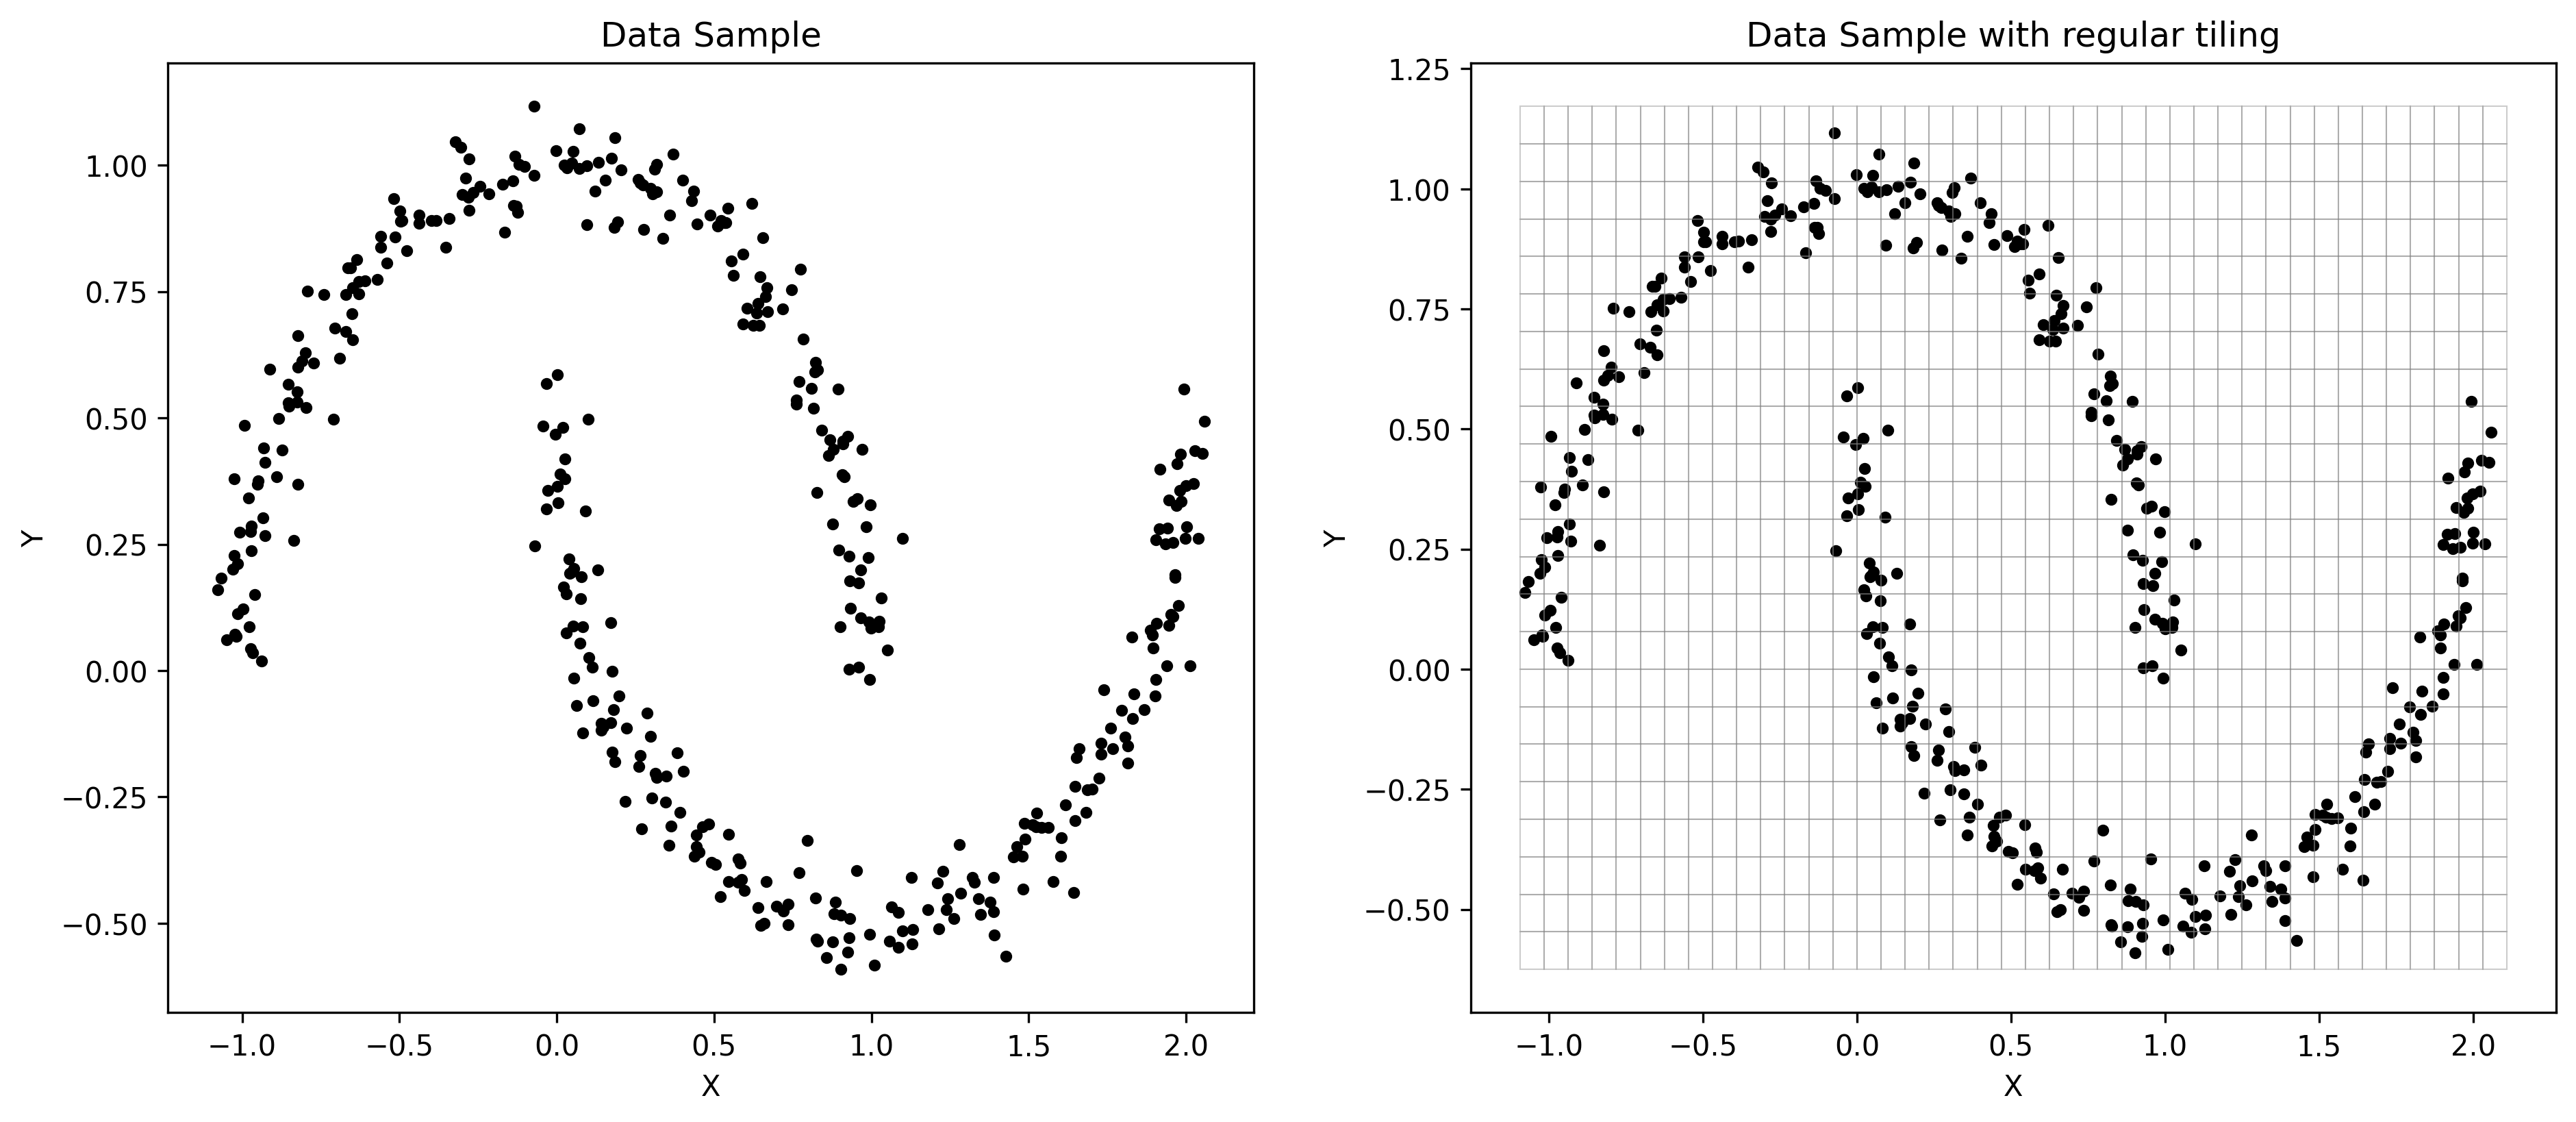

In [4]:
from matplotlib import pyplot as plot
from shapely import from_wkt
from torch_geopooling.transforms import TileWKT


fig, (ax0, ax1) = plot.subplots(ncols=2)
fig.set_size_inches(15, 6)
fig.set_dpi(300)

for ax in (ax0, ax1):
    ax.scatter(X[:, 0], X[:, 1], color="black", s=10)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

ax0.set_title("Data Sample")
ax1.set_title("Data Sample with regular tiling")

tile_wkt = TileWKT(exterior=pool.exterior)
for wkt in tile_wkt(pool.tiles):
    poly = from_wkt(wkt)
    ax1.fill(*poly.exterior.xy, facecolor="none", edgecolor="gray", alpha=0.4, lw=0.5)

## Restricted Regular Tiling

Alternatively, we can prune unnecessary rectangles from the model's layer by building more conservative boundary. There are multiple ways of doing that, but here we present an approach that is based on [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).

The idea is quite naive: we will build a Deulanay triangulation from the input points, and then filter edges that exceed a selected threshold. Here we propose to filter edges, whose length is less than $\mu + 3\cdot\sigma$, where $\mu$ - is a mean length of the edge and $\sigma$ - is standard deviation.

In [5]:
import numpy as np
from shapely import MultiPoint
from shapely import LineString
from shapely.ops import triangulate

points = MultiPoint(X)

# This approach is computationally inefficient as triangulation happens twice,
# but for the education purpose it's left like this as it's less complicated.
faces = triangulate(points, edges=False)
edges = np.array(triangulate(points, edges=True))

# Compute statistics from the lengths of the edges, and use them to filter faces
# (i.e. triangles) with long edges (mu + 3 * sigma).
edges_length = np.array([edge.length for edge in edges])

mu = edges_length.mean()
sigma = edges_length.std()

faces_filtered = []
for face in faces:
    face_coords = list(face.exterior.coords)
    include = True
    
    for i in range(4):
        j = (i + 1) % 3
        ls = LineString([face_coords[i], face_coords[j]])
        if ls.length > (mu + 3 * sigma):
            include = False

    if include:
        faces_filtered.append(face)

In the figures below both variants are depicted: (i) original Delaunay triangulation and (ii) triangulation after applying the length filter. We will be using a filtered one as it reduces the area of the final polygon for the pooling layer.

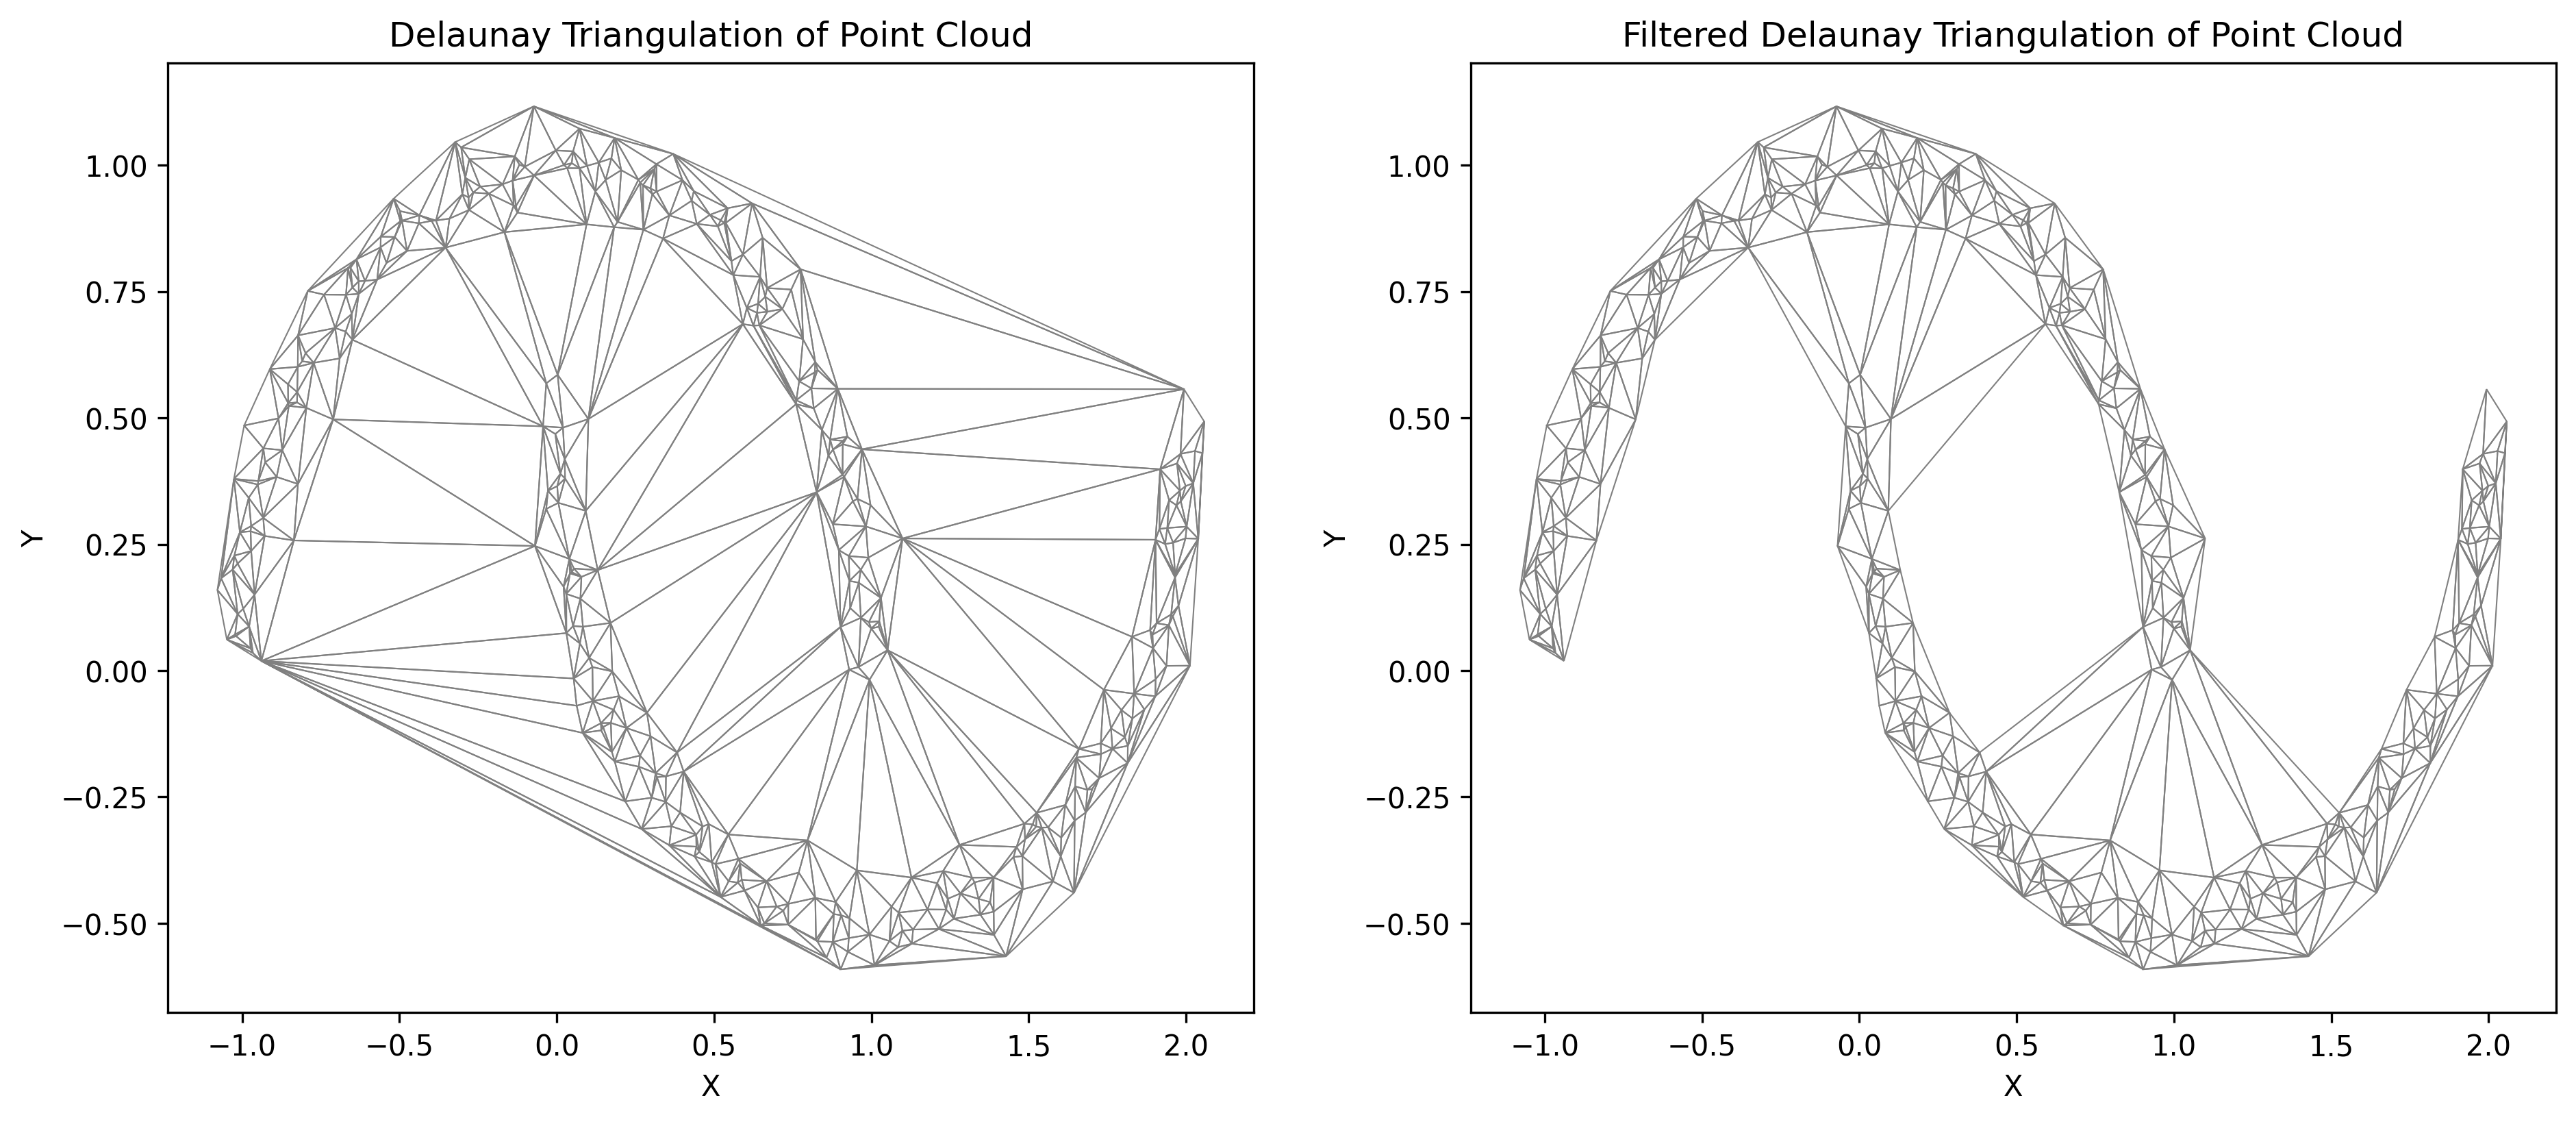

In [6]:
fig, (ax0, ax1) = plot.subplots(ncols=2)
fig.set_size_inches(15, 6)
fig.set_dpi(300)

for face in faces:
    ax0.fill(*face.exterior.xy, facecolor="none", edgecolor="gray", lw=0.5)

for face in faces_filtered:
    ax1.fill(*face.exterior.xy, facecolor="none", edgecolor="gray", lw=0.5)

ax0.set_title("Delaunay Triangulation of Point Cloud")
ax1.set_title("Filtered Delaunay Triangulation of Point Cloud")

for ax in (ax0, ax1):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

Finally, filtered polygons are joined together to create a single polygon, that further will be used in a pooling layer.

In [7]:
from shapely import unary_union

polygon = unary_union(faces_filtered)
pool_filtered = QuadPool2d(1, polygon=polygon, exterior=(-10, -10, 20, 20), max_depth=8)

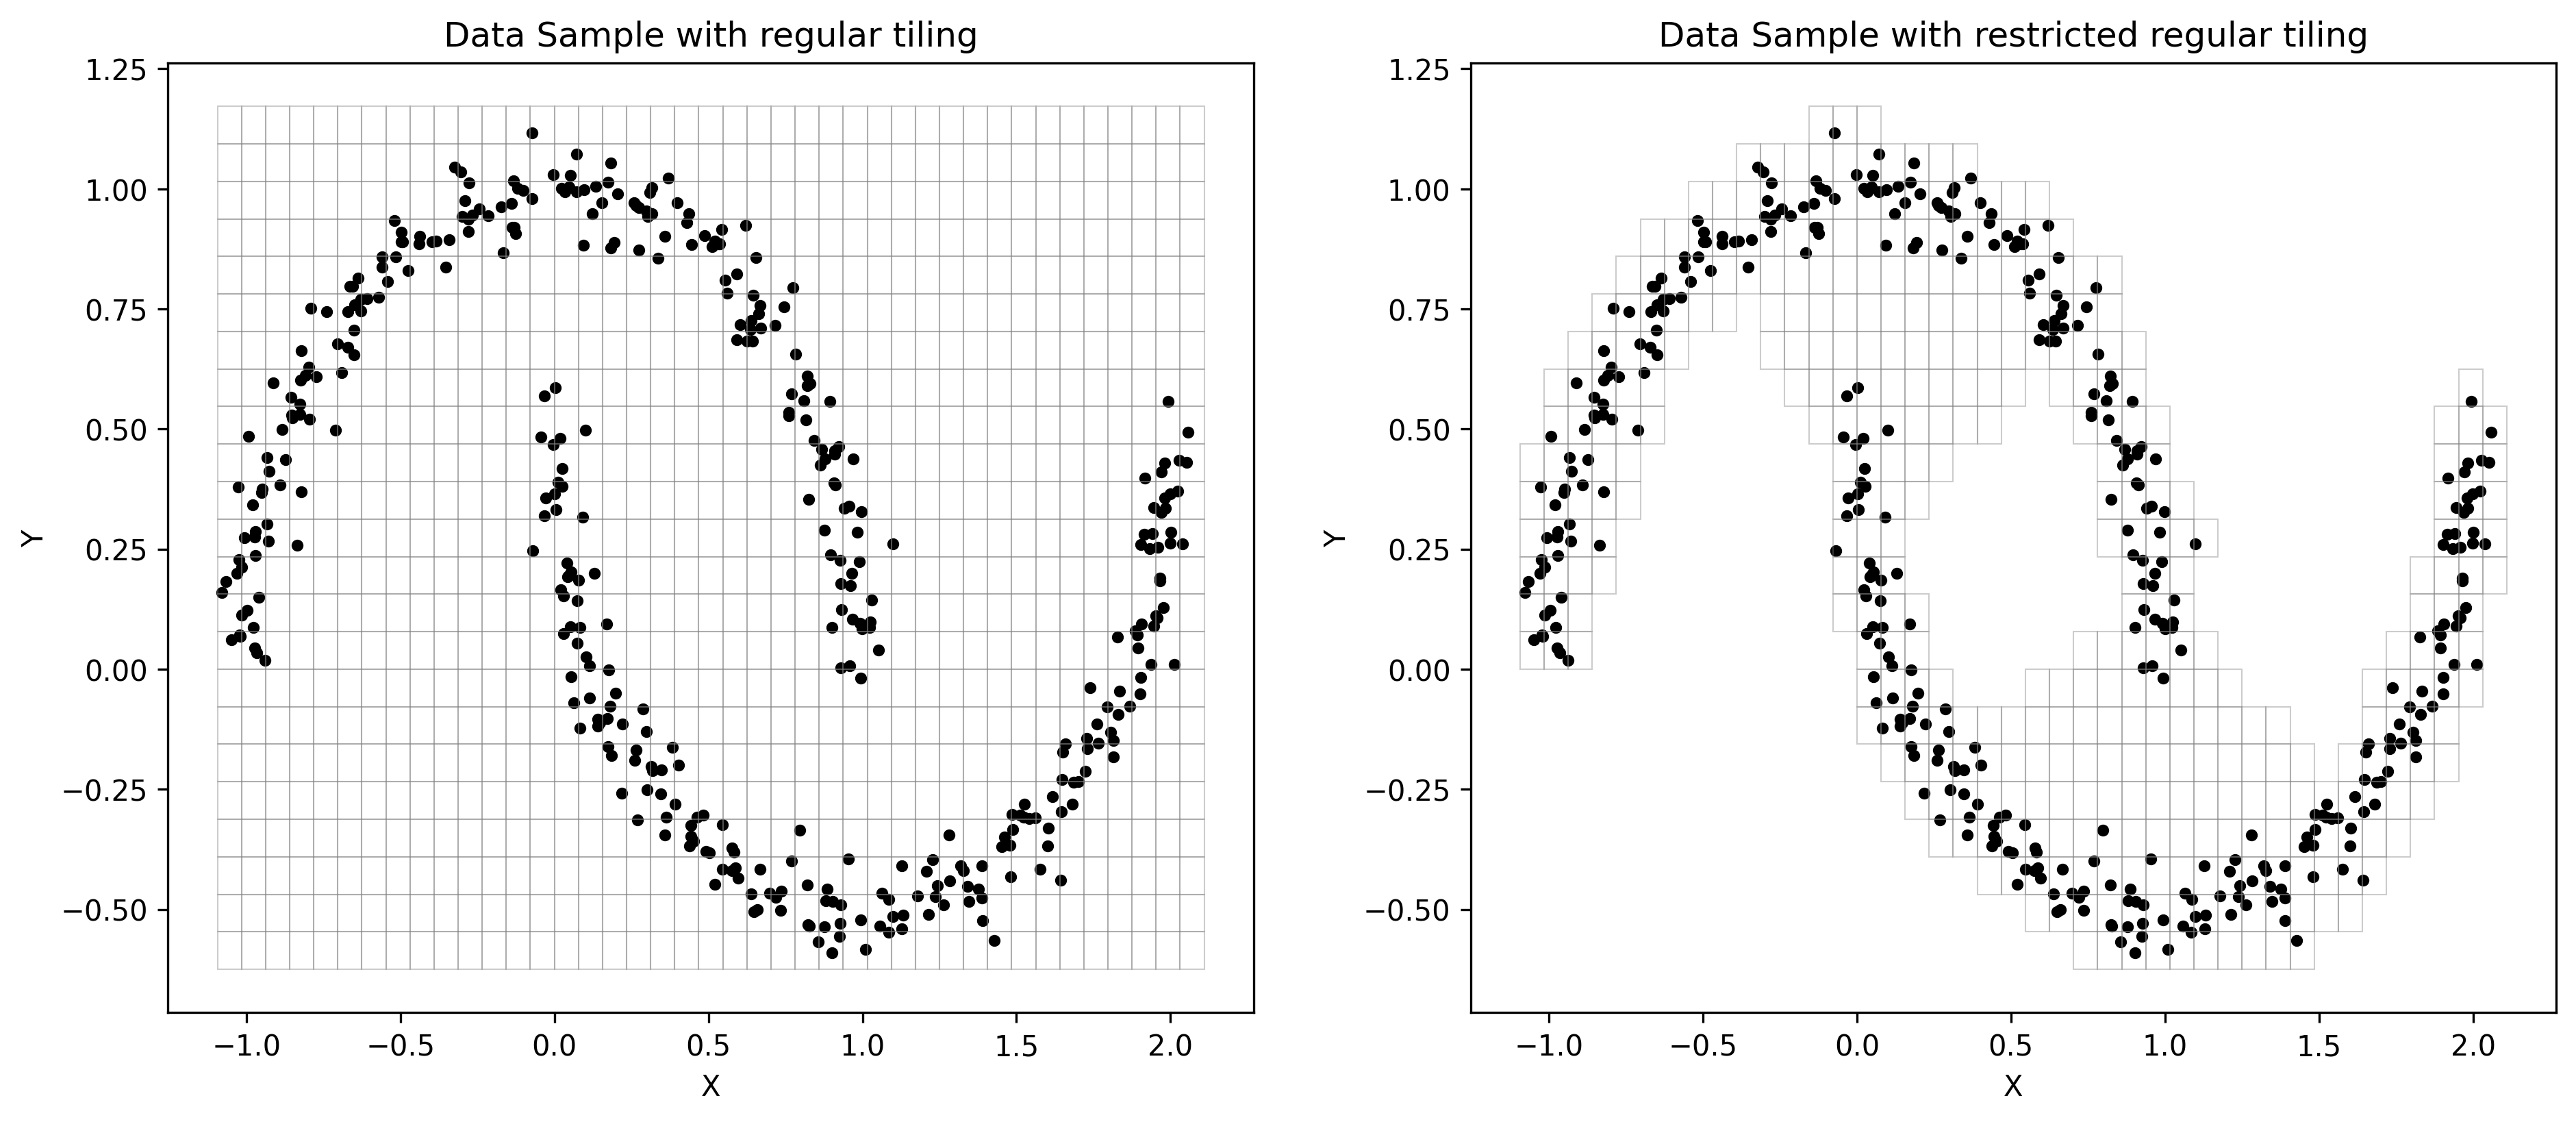

In [8]:
fig, (ax0, ax1) = plot.subplots(ncols=2)
fig.set_size_inches(15, 6)
fig.set_dpi(300)

for ax in (ax0, ax1):
    ax.scatter(X[:, 0], X[:, 1], color="black", s=10)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

ax0.set_title("Data Sample with regular tiling")
ax1.set_title("Data Sample with restricted regular tiling")

tile_wkt = TileWKT(exterior=pool.exterior)

for wkt in tile_wkt(pool.tiles):
    poly = from_wkt(wkt)
    ax0.fill(*poly.exterior.xy, facecolor="none", edgecolor="gray", alpha=0.4, lw=0.5)
    
for wkt in tile_wkt(pool_filtered.tiles):
    poly = from_wkt(wkt)
    ax1.fill(*poly.exterior.xy, facecolor="none", edgecolor="gray", alpha=0.4, lw=0.5)